### SageMaker Stable diffusion Quick Kit - Inference 部署(ControlNet)
   [SageMaker Stable Diffusion Quick Kit](https://github.com/aws-samples/sagemaker-stablediffusion-quick-kit) 提供了一组开箱即用的代码、配置文件，它可以帮助客户在亚马逊云上使用Amazon SageMaker , Lambda, Cloudfront快速构建Stable diffusion AI绘图服务.
   
   ![架构](https://raw.githubusercontent.com/aws-samples/sagemaker-stablediffusion-quick-kit/main/images/architecture.png)


#### 前提条件
1. 亚马逊云账号
2. 建议使用ml.g4dn.xlarge/ml.g5.xlarge

### Notebook部署步骤
1. 升级boto3, sagemaker python sdk
2. 编译docker image
3. 部署AIGC推理服务
    * 配置模型参数
    * 配置异步推理
    * 部署SageMaker Endpoint 
4. 测试ControlNet模型
5. 清除资源


### 0. 升级boto3, sagemaker python sdk

In [5]:
!pip install --upgrade boto3 sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [6]:
#导入对应的库

import re
import os
import json
import uuid

import numpy as np
import pandas as pd
from time import gmtime, strftime


import boto3
import sagemaker

from sagemaker import get_execution_role,session

role = get_execution_role()


sage_session = session.Session()
bucket = sage_session.default_bucket()
aws_region = boto3.Session().region_name


print(f'sagemaker sdk version: {sagemaker.__version__}\nrole:  {role}  \nbucket:  {bucket}')

sagemaker sdk version: 2.148.0
role:  arn:aws:iam::022346938362:role/sd-webui-sm-notebook-ExecutionRole-1K975UHZ65FOK  
bucket:  sagemaker-us-east-1-022346938362


### 1. 准备模型文件

从Civitai网站下载safetensors文件，并将格式转换为 Diffusers 支持的格式。

In [9]:
# 更改 work dir
%cd ~/SageMaker/sagemaker-stablediffusion-quick-kit/inference/sagemaker/byoc

# 安装依赖包
! pip install -e ./diffusers
! pip install transformers omegaconf safetensors

# 下载模型文件
! wget https://civitai.com/api/download/models/16859 -O blueberrymix.safetensors

# 下载模型转换脚本
! git clone https://github.com/huggingface/diffusers

/home/ec2-user/SageMaker/sagemaker-stablediffusion-quick-kit/inference/sagemaker/byoc
ERROR: ./diffusers is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.6 MB/s eta 0:00:0000:01
--2023-04-23 03:23:47--  https://civitai.com/api/download/models/16859
Resolving civitai.com (civitai.com)... 104.26.8.150, 172.67.74.132, 104.26.9.150, ...
Connecting to civitai.com (civitai.com)|104.26.8.150|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://civitai-prod-settled.5ac0637cfd0766c97916cefa3764fbdf.r2.cloudflarestorage.com/380300/t

In [12]:
# 执行模型转换脚本
!python diffusers/scripts/convert_original_stable_diffusion_to_diffusers.py \
  --checkpoint_path ./blueberrymix.safetensors \
  --dump_path ./model_output \
  --from_safetensors

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/convert_from_ckpt.py:1050: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_path, framework="pt", device="cpu") as f:
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/torch/storage.py:899: UserWa

查看输出文件，格式类似：
```
total 32
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:34 feature_extractor
-rw-rw-r-- 1 ec2-user ec2-user  579 Apr 20 03:33 model_index.json
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:33 safety_checker
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:33 scheduler
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:33 text_encoder
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:33 tokenizer
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:33 unet
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:33 vae
```

In [13]:
!ls -l ./model_output

total 32
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 23 03:40 feature_extractor
-rw-rw-r-- 1 ec2-user ec2-user  579 Apr 23 03:40 model_index.json
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 23 03:40 safety_checker
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 23 03:40 scheduler
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 23 03:37 text_encoder
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 23 03:40 tokenizer
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 23 03:40 unet
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 23 03:37 vae


In [14]:
# 上传模型文件到S3
real_model_s3_path = 's3://{0}/{1}/assets/blueberry/uncompressed/'.format(bucket, 'stablediffusion')
!aws s3 sync ./model_output $real_model_s3_path

upload: model_output/model_index.json to s3://sagemaker-us-east-1-022346938362/stablediffusion/assets/blueberry/uncompressed/model_index.json
upload: model_output/feature_extractor/preprocessor_config.json to s3://sagemaker-us-east-1-022346938362/stablediffusion/assets/blueberry/uncompressed/feature_extractor/preprocessor_config.json
upload: model_output/scheduler/scheduler_config.json to s3://sagemaker-us-east-1-022346938362/stablediffusion/assets/blueberry/uncompressed/scheduler/scheduler_config.json
upload: model_output/safety_checker/config.json to s3://sagemaker-us-east-1-022346938362/stablediffusion/assets/blueberry/uncompressed/safety_checker/config.json
upload: model_output/text_encoder/config.json to s3://sagemaker-us-east-1-022346938362/stablediffusion/assets/blueberry/uncompressed/text_encoder/config.json
upload: model_output/safety_checker/pytorch_model.bin to s3://sagemaker-us-east-1-022346938362/stablediffusion/assets/blueberry/uncompressed/safety_checker/pytorch_model.bi

In [16]:
## 查看S3文件
!aws s3 ls --recursive $real_model_s3_path

2023-04-23 03:50:57        520 stablediffusion/assets/blueberry/uncompressed/feature_extractor/preprocessor_config.json
2023-04-23 03:50:57        579 stablediffusion/assets/blueberry/uncompressed/model_index.json
2023-04-23 03:50:57       4584 stablediffusion/assets/blueberry/uncompressed/safety_checker/config.json
2023-04-23 03:50:57 1216064769 stablediffusion/assets/blueberry/uncompressed/safety_checker/pytorch_model.bin
2023-04-23 03:50:57        460 stablediffusion/assets/blueberry/uncompressed/scheduler/scheduler_config.json
2023-04-23 03:51:07        612 stablediffusion/assets/blueberry/uncompressed/text_encoder/config.json
2023-04-23 03:51:07  492307041 stablediffusion/assets/blueberry/uncompressed/text_encoder/pytorch_model.bin
2023-04-23 03:51:12     524619 stablediffusion/assets/blueberry/uncompressed/tokenizer/merges.txt
2023-04-23 03:51:12        472 stablediffusion/assets/blueberry/uncompressed/tokenizer/special_tokens_map.json
2023-04-23 03:51:12        737 stablediffusi

### 2. 编译docker image

需要给当前的执行环境(Notebook Instance / Studio) 绑定的 IAM role 附加访问 ECR 镜像仓库的权限。

测试环境下，可以直接赋予 'AmazonEC2ContainerRegistryFullAccess' 策略。

In [17]:
!./build_push.sh

Using default tag: latest
latest: Pulling from o7x6j3x6/sd-dreambooth-finetuning-v2
Digest: sha256:0140c9f9650458d39f63c3d4ada64eee96984b955117bea59db9749f031b3403
Status: Image is up to date for public.ecr.aws/o7x6j3x6/sd-dreambooth-finetuning-v2:latest
public.ecr.aws/o7x6j3x6/sd-dreambooth-finetuning-v2:latest
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Cloning into 'sd_dreambooth_extension'...
remote: Enumerating objects: 1957, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 1957 (delta 125), reused 172 (delta 111), pack-reused 1762
Receiving objects: 100% (1957/1957), 10.25 MiB | 34.77 MiB/s, done.
Resolving deltas: 100% (1239/1239), done.
Sending 

### 3. 部署AIGC推理服务

#### 3.1 创建dummy model_data 文件(真正的模型使用code/infernece.py进行加载)

In [18]:
!touch dummy
!tar czvf model.tar.gz dummy sagemaker-logo-small.png
assets_dir = 's3://{0}/{1}/assets/'.format(bucket, 'stablediffusion')
model_data = 's3://{0}/{1}/assets/model.tar.gz'.format(bucket, 'stablediffusion')
!aws s3 cp model.tar.gz $assets_dir
!rm -f dummy model.tar.gz

dummy
sagemaker-logo-small.png
upload: ./model.tar.gz to s3://sagemaker-us-east-1-022346938362/stablediffusion/assets/model.tar.gz


#### 3.2 创建 model 配置

In [19]:

boto3_session = boto3.session.Session()
current_region=boto3_session.region_name

client = boto3.client("sts")
account_id=client.get_caller_identity()["Account"]

client = boto3.client('sagemaker')

#使用步骤2编译好的docker images
container = f'{account_id}.dkr.ecr.{current_region}.amazonaws.com/sd-inference-v2'

model_data = f's3://{bucket}/stablediffusion/assets/model.tar.gz'


model_name = 'AIGC-Quick-Kit-' +  strftime("%Y-%m-%d-%H-%M-%S", gmtime())
role = get_execution_role()


# model_name: 支持多种格式
#  - 'runwayml/stable-diffusion-v1-5' 从 hf 下载预训练模型
#  - 's3://bkt/folder/blueberrymix_model.tar.gz' 从s3下载模型压缩文件
#  - 's3://bkt/folder/' 从 s3 文件夹下载未压缩模型文件
primary_container = {
    'Image': container,
    'ModelDataUrl': model_data, # fake model file
    'Environment':{
        's3_bucket': bucket,
        'control_net_enable': 'false',
        'watermarket': 'false',
        'model_name': real_model_s3_path # 真正的 SD 模型文件
    }
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container,
)

create_model_response

{'ModelArn': 'arn:aws:sagemaker:us-east-1:022346938362:model/aigc-quick-kit-2023-04-23-03-55-53',
 'ResponseMetadata': {'RequestId': '3c179ee4-c172-4385-a5e4-3407c59f209a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3c179ee4-c172-4385-a5e4-3407c59f209a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '96',
   'date': 'Sun, 23 Apr 2023 03:55:53 GMT'},
  'RetryAttempts': 0}}

In [20]:
_time_tag = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
_variant_name =  'AIGC-Quick-Kit-'+ _time_tag
endpoint_config_name = 'AIGC-Quick-Kit-' +  _time_tag

response = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': _variant_name,
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.g4dn.2xlarge',
            'InitialVariantWeight': 1
        },
    ]
    ,
    AsyncInferenceConfig={
        'OutputConfig': {
            'S3OutputPath': f's3://{bucket}/stablediffusion/asyncinvoke/out/'
        }
    }
)

#### 3.3 部署SageMaker endpoint

In [21]:
endpoint_name = f'AIGC-Quick-Kit-{str(uuid.uuid4())}'


response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
    
)



print(f'终端节点:{endpoint_name} 正在创建中，首次启动中会加载模型，请耐心等待, 请在控制台上查看状态')


终端节点:AIGC-Quick-Kit-908fe2db-e8bc-4d6c-9d0d-221eb6bfb77b 正在创建中，首次启动中会加载模型，请耐心等待, 请在控制台上查看状态


### 4. 测试

### 4.1 辅助方法 

In [22]:
import time
import uuid
import io
import traceback
from PIL import Image


s3_resource = boto3.resource('s3')

def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key


def predict_async(endpoint_name,payload):
    runtime_client = boto3.client('runtime.sagemaker')
    input_file=str(uuid.uuid4())+".json"
    s3_resource = boto3.resource('s3')
    s3_object = s3_resource.Object(bucket, f'stablediffusion/asyncinvoke/input/{input_file}')
    payload_data = json.dumps(payload).encode('utf-8')
    s3_object.put( Body=bytes(payload_data))
    input_location=f's3://{bucket}/stablediffusion/asyncinvoke/input/{input_file}'
    print(f'input_location: {input_location}')
    response = runtime_client.invoke_endpoint_async(
        EndpointName=endpoint_name,
        InputLocation=input_location
    )
    result =response.get("OutputLocation",'')
    print('result', result)
    wait_async_result(result)


def s3_object_exists(s3_path):
    """
    s3_object_exists
    """
    try:
        s3 = boto3.client('s3')
        base_name=os.path.basename(s3_path)
        _,ext_name=os.path.splitext(base_name)
        bucket,key=get_bucket_and_key(s3_path)
        
        s3.head_object(Bucket=bucket, Key=key)
        return True
    except Exception as ex:
        print("job is not completed, waiting...")   
        return False
    
def draw_image(output_location):
    try:
        bucket, key = get_bucket_and_key(output_location)
        obj = s3_resource.Object(bucket, key)
        body = obj.get()['Body'].read().decode('utf-8') 
        predictions = json.loads(body)
        print(predictions['result'])
        for image in predictions['result']:
            bucket, key = get_bucket_and_key(image)
            obj = s3_resource.Object(bucket, key)
            bytes = obj.get()['Body'].read()
            image = Image.open(io.BytesIO(bytes))
            #resize image to 50% size
            half = 0.5
            out_image = image.resize( [int(half * s) for s in image.size] )
            out_image.show()
    except Exception as e:
        print("result is not completed, waiting...")   
    

    
def wait_async_result(output_location,timeout=60):
    current_time=0
    while current_time<timeout:
        if s3_object_exists(output_location):
            print("have async result")
            draw_image(output_location)
            break
        else:
            time.sleep(5)

            
def check_sendpoint_status(endpoint_name):
    client = boto3.client('sagemaker')
    response = client.describe_endpoint(
        EndpointName=endpoint_name
    )
    if response['EndpointStatus'] !='InService':
        raise Exception (f'{endpoint_name} not ready , please wait....')
    else:
        status = response['EndpointStatus']
        print(f'{endpoint_name} is ready, status: {status}')

#### 检查endpoint 状态

In [23]:
check_sendpoint_status(endpoint_name)

AIGC-Quick-Kit-908fe2db-e8bc-4d6c-9d0d-221eb6bfb77b is ready, status: InService


### 4.1 测试



input_location: s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/input/a013ba27-024b-4913-a751-74b3dc085af5.json
result s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/out/3ea8e0d8-01c5-4bb5-82b2-dc9e2764eff4.out
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
have async result
['s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/images/2c732ae7-23c1-4925-a2be-d313239f636a.jpg', 's3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/images/776df047-3fff-4fcc-9b54-b8222abaf22a.jpg']


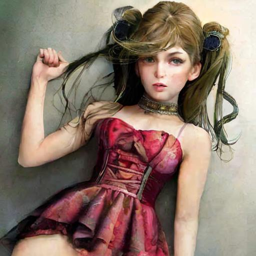

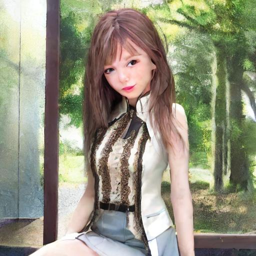

In [24]:

payload={
    "prompt": "best quality, 1girl",
    "negative_prompt":"",
    "steps":20,
    "sampler":"dpm2_a",
    "seed":2589384173,
    "height": 512, 
    "width": 512,
    "count":2,
    "guidance_scale": 7,
}

predict_async(endpoint_name,payload)


### 5 清除资源

In [ ]:
response = client.delete_endpoint(
    EndpointName=endpoint_name
    
)

response = client.delete_endpoint_config(
    EndpointConfigName=endpoint_config_name
)


print(f'终端节点:{endpoint_name} 已经被清除，请在控制台上查看状态')
